In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#  data loading 
data_folder = "/home/subblue-3/nextGen/data/attitude_estimation_in_lab_20250820/"
output_roll_folder = "/home/subblue-3/nextGen/estimate_attitude/output_results/roll/"
output_pitch_folder = "/home/subblue-3/nextGen/estimate_attitude/output_results/pitch/"


df_roll_train = pd.read_excel(data_folder + "6_roll__train.xlsx")
df_roll_val = pd.read_excel(data_folder + "6_roll__val.xlsx")
df_roll_test = pd.read_excel(data_folder + "6_roll__test.xlsx")

df_pitch_train_origian = pd.read_excel(data_folder + "6_pitch__train.xlsx")
df_pitch_val_origian = pd.read_excel(data_folder + "6_pitch__val.xlsx")
df_pitch_test_origian = pd.read_excel(data_folder + "6_pitch__test.xlsx")


df_roll_train.shape, df_roll_val.shape, df_roll_test.shape, df_pitch_train_origian.shape, df_pitch_val_origian.shape, df_pitch_test_origian.shape
print("Dataset shapes:")
print(f"Train: {df_pitch_train_origian.shape}")
print(f"Validation: {df_pitch_val_origian.shape}")
print(f"Test: {df_pitch_test_origian.shape}")


# Data preprocessing
def prepare_data(df_train, df_val, df_test):
    """
    Prepare and preprocess the data for training
    """
    # Separate features (X) and target (y)
    # All columns except 'pitch_true' are features
    X_train = df_train.drop('pitch_true', axis=1).values  # Convert to numpy array
    y_train = df_train['pitch_true'].values  # Target values
    
    X_val = df_val.drop('pitch_true', axis=1).values
    y_val = df_val['pitch_true'].values
    
    X_test = df_test.drop('pitch_true', axis=1).values
    y_test = df_test['pitch_true'].values
    
    # Standardize features (mean=0, std=1)
    # This helps neural networks train faster and more stably
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)  # Fit on training data only
    X_val_scaled = scaler_X.transform(X_val)  # Use same scaler for validation
    X_test_scaled = scaler_X.transform(X_test)  # Use same scaler for test
    print(f"X_train_scaled: {X_train_scaled.shape}")
    print(f"X_val_scaled: {X_val_scaled.shape}")
    
    # Standardize target values (optional but often helpful)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_X, scaler_y)

# Prepare the data
X_train_scaled, y_train, X_val, y_val, X_test, y_test, scaler_X, scaler_y = prepare_data(
    df_pitch_train_origian, df_pitch_val_origian, df_pitch_test_origian
)

print(f"Feature dimensions: {X_train_scaled.shape[1]}")
print(f"Training samples: {X_train_scaled.shape[0]}")

# Custom Dataset class for PyTorch
class PitchDataset(Dataset):
    """
    Custom dataset class that inherits from torch.utils.data.Dataset
    This allows us to use PyTorch's DataLoader for batch processing
    """
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        self.X = torch.FloatTensor(X)  # Features as float tensors
        self.y = torch.FloatTensor(y)  # Targets as float tensors
    
    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.X)
    
    def __getitem__(self, idx):
        # Return a single sample (features, target) at given index
        return self.X[idx], self.y[idx]

# Create dataset instances
train_dataset = PitchDataset(X_train_scaled, y_train)
val_dataset = PitchDataset(X_val, y_val)
test_dataset = PitchDataset(X_test, y_test)

# Create data loaders for batch processing
batch_size = 64  # Number of samples per batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network architecture
class PitchNN(nn.Module):
    """
    Neural Network for pitch estimation
    """
    def __init__(self, input_dim, hidden_dims=[32, 64, 128, 64, 32], dropout_rate=0):   # dropout_rate=0.3
        super(PitchNN, self).__init__()  # Initialize parent class
        
        # Create a list to store all layers
        layers = []
        
        # Input dimension
        prev_dim = input_dim
        
        # Add hidden layers
        for hidden_dim in hidden_dims:
            # Linear (fully connected) layer
            layers.append(nn.Linear(prev_dim, hidden_dim))
            # Batch normalization (helps with training stability)
            layers.append(nn.BatchNorm1d(hidden_dim))
            # ReLU activation function
            layers.append(nn.ReLU())
            # Dropout for regularization (prevents overfitting)
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer (no activation since it's regression)
        layers.append(nn.Linear(prev_dim, 1))  # Single output for regression
        
        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # Forward pass through the network
        return self.network(x).squeeze()  # Remove extra dimensions

# Initialize the model
input_dim = X_train_scaled.shape[1]  # Number of input features
model = PitchNN(input_dim=input_dim)
model = model.to(device)  # Move model to GPU if available

print(f"Model architecture:")
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adam optimizer

# Learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train the model for one epoch
    """
    model.train()  # Set model to training mode
    total_loss = 0
    num_batches = 0
    
    for X_batch, y_batch in train_loader:
        # Move data to device (GPU if available)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Zero the gradients from previous iteration
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(X_batch)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Accumulate loss
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# Validation function
def validate(model, val_loader, criterion, device):
    """
    Evaluate the model on validation data
    """
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm updates)
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches


Using device: cpu
Dataset shapes:
Train: (102, 12)
Validation: (18, 12)
Test: (30, 12)
X_train_scaled: (102, 11)
X_val_scaled: (18, 11)
Feature dimensions: 11
Training samples: 102
Model architecture:
PitchNN(
  (network): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0, inplace=False)
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0, inplace=False)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [42]:

# Training loop
num_epochs = 200  # Number of training epochs
train_losses = []  # Store training losses
val_losses = []    # Store validation losses
best_val_loss = float('inf')  # Track best validation loss
patience_counter = 0  # For early stopping
patience = 20  # Stop if no improvement for this many epochs

print("Starting training...")
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_pitch_model.pth')
    else:
        patience_counter += 1
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model for testing
model.load_state_dict(torch.load('best_pitch_model.pth'))

# Testing function
def test_model(model, test_loader, device, scaler_y):
    """
    Test the model and return predictions and actual values
    """
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(X_batch)
            
            # Move to CPU and convert to numpy
            predictions.extend(pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    # Convert back to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    actuals = np.array(actuals).reshape(-1, 1)
    
    predictions_original = scaler_y.inverse_transform(predictions).flatten()
    actuals_original = scaler_y.inverse_transform(actuals).flatten()
    
    return predictions_original, actuals_original

# Test the model
test_predictions, test_actuals = test_model(model, test_loader, device, scaler_y)


Starting training...
Epoch [10/200], Train Loss: 0.0835, Val Loss: 0.5091
Epoch [20/200], Train Loss: 0.0417, Val Loss: 0.1359
Epoch [30/200], Train Loss: 0.0333, Val Loss: 0.0716
Epoch [40/200], Train Loss: 0.0351, Val Loss: 0.0886
Epoch [50/200], Train Loss: 0.0146, Val Loss: 0.0532
Epoch [60/200], Train Loss: 0.0207, Val Loss: 0.0458
Epoch [70/200], Train Loss: 0.0147, Val Loss: 0.0392
Early stopping at epoch 74



Test Results:
Mean Squared Error (MSE): 6.0470
Root Mean Squared Error (RMSE): 2.4591
Mean Absolute Error (MAE): 1.8153
R² Score: 0.9748


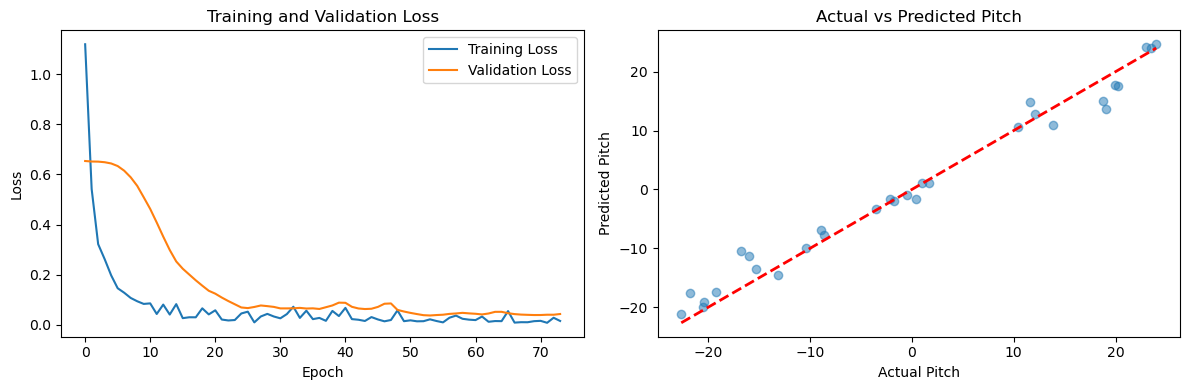


Model training and evaluation completed!
Best model saved as 'best_pitch_model.pth'


In [43]:

# Calculate evaluation metrics
mse = mean_squared_error(test_actuals, test_predictions)
mae = mean_absolute_error(test_actuals, test_predictions)
r2 = r2_score(test_actuals, test_predictions)
rmse = np.sqrt(mse)

print("\nTest Results:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(test_actuals, test_predictions, alpha=0.5)
plt.plot([test_actuals.min(), test_actuals.max()], [test_actuals.min(), test_actuals.max()], 'r--', lw=2)
plt.xlabel('Actual Pitch')
plt.ylabel('Predicted Pitch')
plt.title('Actual vs Predicted Pitch')

plt.tight_layout()
plt.show()

# Function to make predictions on new data
def predict_pitch(model, new_data, scaler_X, scaler_y, device):
    """
    Make predictions on new data
    """
    model.eval()
    
    # Preprocess new data
    new_data_scaled = scaler_X.transform(new_data)
    new_tensor = torch.FloatTensor(new_data_scaled).to(device)
    
    with torch.no_grad():
        predictions_scaled = model(new_tensor)
        predictions_original = scaler_y.inverse_transform(
            predictions_scaled.cpu().numpy().reshape(-1, 1)
        ).flatten()
    
    return predictions_original

print("\nModel training and evaluation completed!")
print(f"Best model saved as 'best_pitch_model.pth'")


In [35]:
test_actuals

array([ -0.46     , -20.54     ,  13.83     ,   0.98     ,   0.4400001,
       -15.320001 ,  -3.4899998,  22.949999 ,  -2.1      ,   1.7199999,
        12.120001 , -21.810001 , -13.19     , -22.640001 , -20.45     ,
        -8.58     ,  10.370001 ,  -1.77     ,  -8.94     ,  20.259998 ,
       -16.800001 ,  18.759998 , -19.28     ,  19.049997 ,  19.949999 ,
        23.989998 ,  11.580001 ,  23.48     , -10.43     , -16.01     ],
      dtype=float32)

Complete model saved to 'pitch_complete_model.pth'


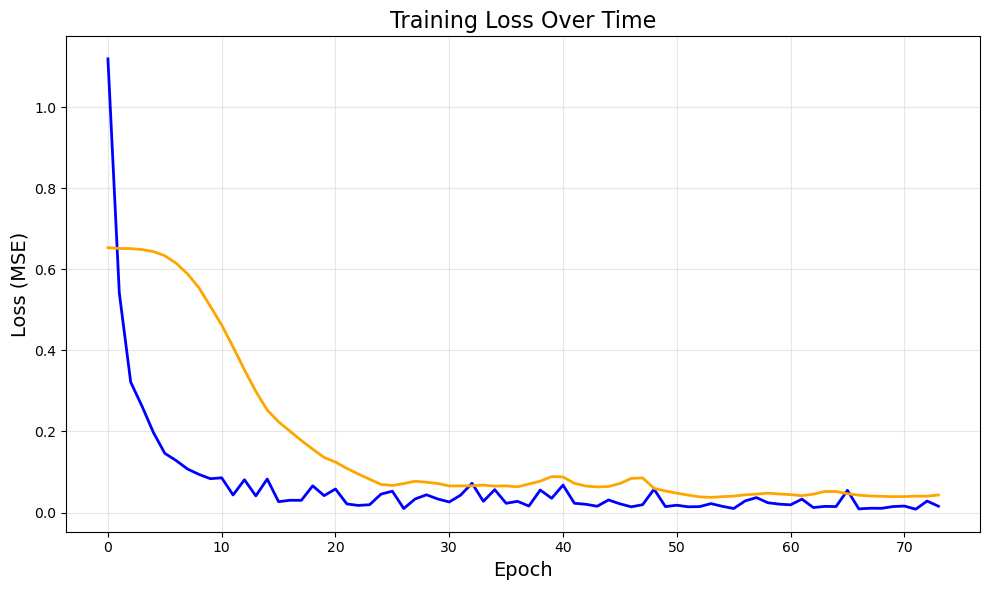

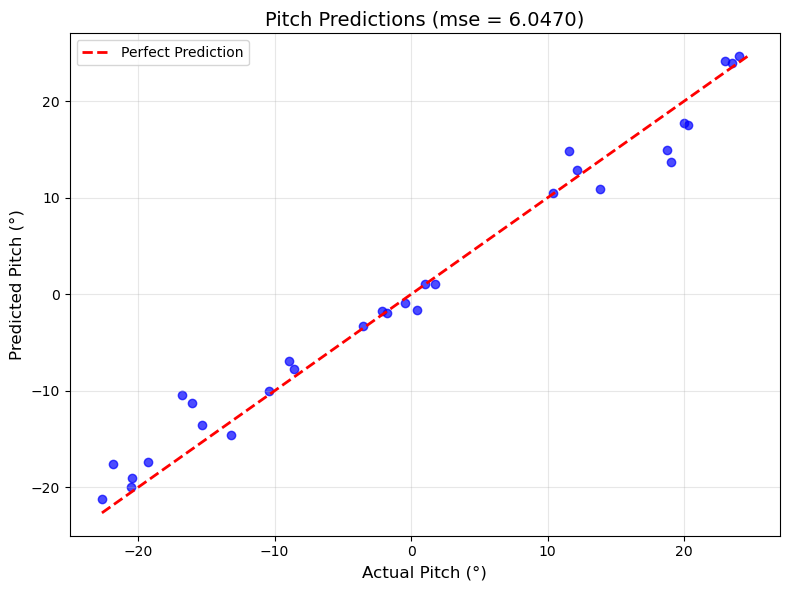

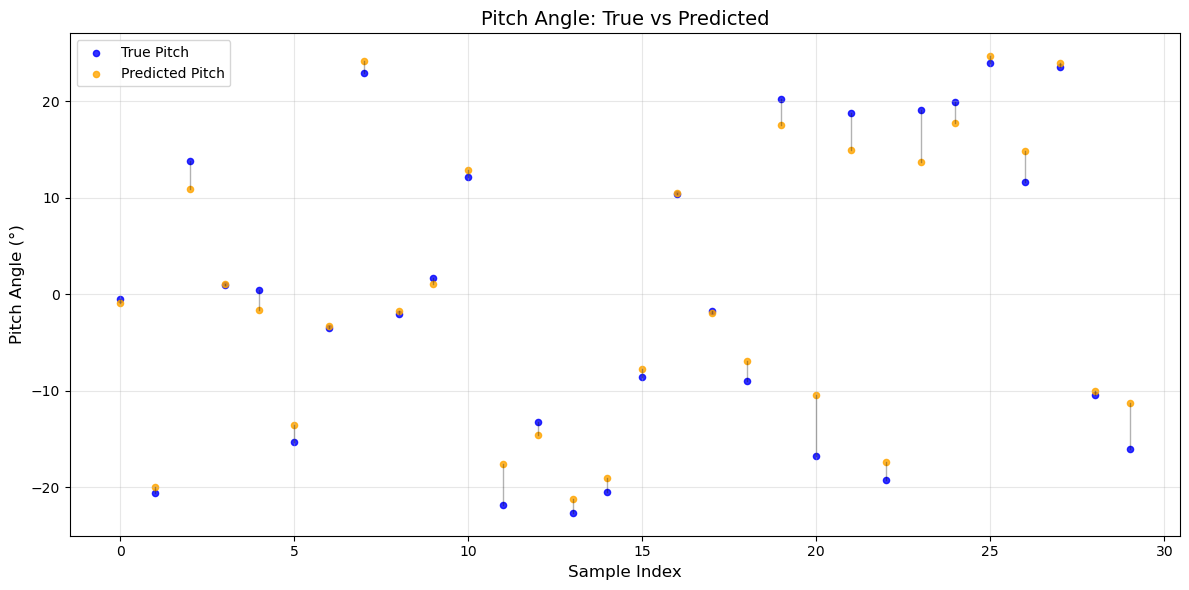

All plots saved to local files:
- training_loss_matplotlib.png
- training_loss_plotly.html/png
- diagonal_predictions_matplotlib.png
- diagonal_predictions_plotly.html/png
- timeseries_predictions_matplotlib.png
- timeseries_predictions_plotly.html/png


In [47]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Add this after the training loop (after calculating metrics)

# Save model and scalers
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'input_size': X_train_scaled.shape[1]
}, 'pitch_complete_model.pth')
print("Complete model saved to 'pitch_complete_model.pth'")

# Plot training process with matplotlib
plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
plt.plot(val_losses, '-', color='orange', linewidth=2, label='Validation Loss')
plt.title('Training Loss Over Time', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss (MSE)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pitch_training_loss.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training process with plotly
fig_training = go.Figure()
fig_training.add_trace(go.Scatter(
    x=list(range(len(train_losses))),
    y=train_losses,
    mode='lines',
    name='Training Loss',
    line=dict(color='blue', width=2)
))
fig_training.update_layout(
    title='Training Loss Over Time',
    xaxis_title='Epoch',
    yaxis_title='Loss (MSE)',
    template='plotly_white',
    width=800,
    height=500
)
fig_training.update_layout()
fig_training.show()

# fig_training.write_html('training_loss_plotly.html')
# fig_training.write_image('training_loss_plotly.png', width=800, height=500, scale=2)

# Test results - Figure 1: Diagonal plots (Actual vs Predicted)
# Pitch diagonal plot
plt.figure(figsize=(8, 6))

plt.scatter(test_actuals, test_predictions, alpha=0.7, color='blue')
min_val = min(test_actuals.min(), test_predictions.min())
max_val = max(test_actuals.max(), test_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Pitch (°)', fontsize=12)
plt.ylabel('Predicted Pitch (°)', fontsize=12)
plt.title(f'Pitch Predictions (mse = {mse:.4f})', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pitch_test__diagonal.png', dpi=300, bbox_inches='tight')
plt.show()

# Test results - Figure 2: Time series plot (Index vs Angle values)
plt.figure(figsize=(12, 6))
indices = range(len(test_actuals))

# Pitch time series
plt.scatter(indices, test_actuals, color='blue', label='True Pitch', alpha=0.8, s=20)
plt.scatter(indices, test_predictions, color='orange', label='Predicted Pitch', alpha=0.8, s=20)
for i in indices:
    plt.plot([i, i], [test_actuals[i], test_predictions[i]], 'k-', alpha=0.3, linewidth=1)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Pitch Angle (°)', fontsize=12)
plt.title('Pitch Angle: True vs Predicted', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pitch_test__true_vs_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotly version of diagonal plots
fig_diagonal = go.Figure()

# Pitch diagonal
fig_diagonal.add_trace(
    go.Scatter(x=test_actuals, y=test_predictions, mode='markers',
               name='Pitch Predictions', marker=dict(color='blue', opacity=0.7))
)
min_val = min(test_actuals.min(), test_predictions.min())
max_val = max(test_actuals.max(), test_predictions.max())
fig_diagonal.add_trace(
    go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines',
               name='Perfect Prediction', line=dict(color='red', dash='dash'))
)

fig_diagonal.update_xaxes(title_text="Actual Pitch (°)")
fig_diagonal.update_yaxes(title_text="Predicted Pitch (°)")
fig_diagonal.update_layout(
    title=f'Pitch Predictions (MSE = {mse:.4f})',
    template='plotly_white', 
    width=800, 
    height=600
)
# fig_diagonal.write_html('diagonal_predictions_plotly.html')
# fig_diagonal.write_image('diagonal_predictions_plotly.png', width=800, height=600, scale=2)

# Plotly version of time series
fig_timeseries = go.Figure()

indices = list(range(len(test_actuals)))

# Pitch time series
fig_timeseries.add_trace(
    go.Scatter(x=indices, y=test_actuals, mode='markers',
               name='True Pitch', marker=dict(color='blue', size=6))
)
fig_timeseries.add_trace(
    go.Scatter(x=indices, y=test_predictions, mode='markers',
               name='Predicted Pitch', marker=dict(color='orange', size=6))
)

fig_timeseries.update_xaxes(title_text="Sample Index")
fig_timeseries.update_yaxes(title_text="Pitch Angle (°)")
fig_timeseries.update_layout(
    title='Pitch Angle: True vs Predicted',
    template='plotly_white', 
    width=1000, 
    height=600
)
fig_timeseries.update_layout()
fig_timeseries.show()
# fig_timeseries.write_html('timeseries_predictions_plotly.html')
# fig_timeseries.write_image('timeseries_predictions_plotly.png', width=1000, height=600, scale=2)

print("All plots saved to local files:")
print("- training_loss_matplotlib.png")
print("- training_loss_plotly.html/png")
print("- diagonal_predictions_matplotlib.png")
print("- diagonal_predictions_plotly.html/png")
print("- timeseries_predictions_matplotlib.png")
print("- timeseries_predictions_plotly.html/png")

In [ ]:
#### plot test results